# QuTiPv5 Paper Example: Floquet Speed Test

Authors: Maximilian Meyer-Mölleringhof (m.meyermoelleringhof@gmail.com), Marc Gali (galilabarias.marc@aist.go.jp), Neill Lambert (nwlambert@gmail.com), Paul Menczel (paul@menczel.net)

## Introduction

In this example we will discuss Hamiltonians with periodic time-dependence and how we can solve the time evolution of the system in QuTiP.
A natural approach to this is using the Floquet theorem [\[1, 2\]](#References).
Similar to the Bloch theorem (for spatial periodicity), this method helps to drastically simplify the problem.
Let $H$ be a time-dependent and periodic Hamiltonian with period $T$, such that

$H(t) = H(t + T)$

Following Floquet's theorem, there exist solutions to the Schrödinger equation that take the form

$\ket{\psi_\alpha (t)} = \exp(-i \epsilon_\alpha t / \hbar) \ket{\Psi_\alpha (t)}$,

where $\ket{\Psi_\alpha (t)} = \ket{\Psi_\alpha (t + T)}$ are the Floquet modes and $\epsilon_\alpha$ are the quasi-energies.
Any solution of the Schrödinger equation can then be written as a linear combination

$\ket{\psi(t)} = \sum_\alpha c_\alpha \ket{\psi_\alpha(t)}$,

where the constants $c_\alpha$ are determined by the initial conditions.

Inserting the Floquet states above into the Schrödinger equation, we can define the Floquet Hamiltonian,

$H_F(t) = H(t) - i \hbar \dfrac{\partial}{\partial t}$,

which renders the problem time-independent,

$H_F(t) \ket{\Psi_\alpha(t)} = \epsilon_\alpha \ket{\Psi_\alpha(t)}$.

Solving this equation then allows us to find $\ket{\psi (t)}$ at any large $t$.

Our goal in this notebook is to show how this procedure is done in QuTiP and how it compares to the standard `sesolve` method - specifically in terms of computation time.

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
from qutip import (CoreOptions, FloquetBasis, about, basis, expect, qeye,
                   qzero_like, sesolve, sigmax, sigmay, sigmaz, tensor)

%matplotlib inline

## Two-level system with periodic drive

We consider a two-level system that is exposed to a periodic drive:

$H(t) = - \dfrac{\epsilon}{2} \sigma_z - \dfrac{\Delta}{2} \sigma_x + \dfrac{A}{2} \sin(\omega_d t) \sigma_x$,

where $\epsilon$ is the energy splitting, $\Delta$ the coupling strength and $A$ the drive amplitude.

In [2]:
delta = 0.2 * 2 * np.pi
epsilon = 1.0 * 2 * np.pi
A = 2.5 * 2 * np.pi
omega = 1.0 * 2 * np.pi
T = 2 * np.pi / omega

H0 = -1 / 2 * (epsilon * sigmaz() + delta * sigmax())
H1 = A / 2 * sigmax()
args = {"w": omega}
H = [H0, [H1, lambda t, w: np.sin(w * t)]]

In [3]:
psi0 = basis(2, 0)  # initial condition

# Numerical parameters
dt = 0.01
N_T = 10  # Number of periods
tlist = np.arange(0.0, N_T * T, dt)

In [4]:
computational_time_floquet = np.zeros_like(tlist)
computational_time_sesolve = np.zeros_like(tlist)

expect_floquet = np.zeros_like(tlist)
expect_sesolve = np.zeros_like(tlist)

In [5]:
# Running the simulation
for n, t in enumerate(tlist):
    # Floquet basis
    # --------------------------------
    tic_f = time.perf_counter()
    floquetbasis = FloquetBasis(H, T, args)
    # Decomposing inital state into Floquet modes
    f_coeff = floquetbasis.to_floquet_basis(psi0)
    # Obtain evolved state in the original basis
    psi_t = floquetbasis.from_floquet_basis(f_coeff, t)
    p_ex = expect(sigmaz(), psi_t)
    toc_f = time.perf_counter()

    # Saving data
    computational_time_floquet[n] = toc_f - tic_f
    expect_floquet[n] = p_ex

    # sesolve
    # --------------------------------
    tic_f = time.perf_counter()
    psi_se = sesolve(H, psi0, tlist[: n + 1], e_ops=[sigmaz()], args=args)
    p_ex_ref = psi_se.expect[0]
    toc_f = time.perf_counter()

    # Saving data
    computational_time_sesolve[n] = toc_f - tic_f
    expect_sesolve[n] = p_ex_ref[-1]

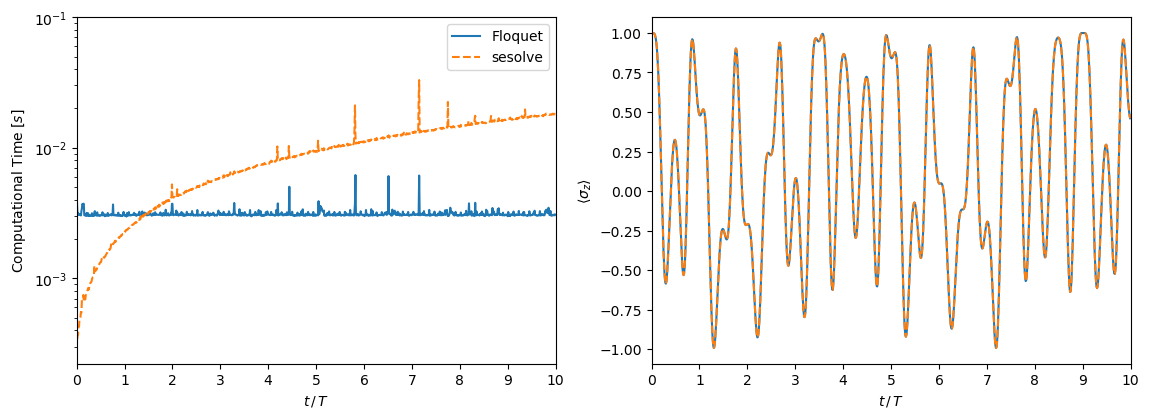

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(13.6, 4.5))
axs[0].plot(tlist / T, computational_time_floquet, "-")
axs[0].plot(tlist / T, computational_time_sesolve, "--")

axs[0].set_yscale("log")
axs[0].set_yticks(np.logspace(-3, -1, 3))
axs[1].plot(tlist / T, np.real(expect_floquet), "-")
axs[1].plot(tlist / T, np.real(expect_sesolve), "--")

axs[0].set_xlabel(r"$t \, / \, T$")
axs[1].set_xlabel(r"$t \, / \, T$")
axs[0].set_ylabel(r"Computational Time [$s$]")
axs[1].set_ylabel(r"$\langle \sigma_z \rangle$")
axs[0].legend(("Floquet", "sesolve"))

xticks = np.rint(np.linspace(0, N_T, N_T + 1, endpoint=True))
axs[0].set_xticks(xticks)
axs[0].set_xlim([0, N_T])
axs[1].set_xticks(xticks)
axs[1].set_xlim([0, N_T])

plt.show()

## One Dimensional Ising Chain

As a second use case for the Floquet method, we look at the one-dimensional Ising chain with a periodic drive.
We describe such a system using the Hamiltonian

$H(t) = g_0 \sum_{n=1}^N \sigma_z^{(n)} - J_0 \sum_{n=1}^{N - 1} \sigma_x^{(n)} \sigma_x^{(n+1)} + A \sin (\omega_d t) \sum_{n=1}^N \sigma_x^{(n)}$,

where $g_0$ is the level splitting, $J_0$ is the nearest-neighbour coupling constant and $A$ is the drive amplitude.

As outlined in the QuTiPv5 paper, it's educational to study the dimensional scaling of the Floquet method compared to the standard `sesolve`.
Specifically how the crossing time (when the Floquet method becomes faster) depends on the dimensions $N$.
Although we will not reproduce the whole plot for computation time reasons, we implement the solution for one specific choice of $N$.
Feel free to play around with the parameters!

In [7]:
N = 4  # number of spins
g0 = 1  # energy-splitting
J0 = 1.4  # coupling strength
A = 1.0  # drive strength
omega = 1.0 * 2 * np.pi  # drive frequency
T = 2 * np.pi / omega  # drive period

In [8]:
# For Hamiltonian Setup
def setup_Ising_drive(N, g0, J0, A, omega, data_type="CSR"):
    """
    # N    : number of spins
    # g0   : splitting,
    # J0   : couplings
    # A    : drive amplitude
    # omega: drive frequency
    """
    with CoreOptions(default_dtype=data_type):

        sx_list, sy_list, sz_list = [], [], []
        for i in range(N):
            op_list = [qeye(2)] * N
            op_list[i] = sigmax().to(data_type)
            sx_list.append(tensor(op_list))
            op_list[i] = sigmay().to(data_type)
            sy_list.append(tensor(op_list))
            op_list[i] = sigmaz().to(data_type)
            sz_list.append(tensor(op_list))

        # Hamiltonian - Energy splitting terms
        H_0 = 0.0
        for i in range(N):
            H_0 += g0 * sz_list[i]

        # Interaction terms
        H_1 = qzero_like(H_0)
        for n in range(N - 1):
            H_1 += -J0 * sx_list[n] * sx_list[n + 1]

        # Driving terms
        if A > 0:
            H_d = 0.0
            for i in range(N):
                H_d += A * sx_list[i]
            args = {"w": omega}
            H = [H_0, H_1, [H_d, lambda t, w: np.sin(w * t)]]
        else:
            args = {}
            H = [H_0, H_1]

        # Defining initial conditions
        state_list = [basis(2, 1)] * (N - 1)
        state_list.append(basis(2, 0))
        psi0 = tensor(state_list)

        # Defining expectation operator
        e_ops = sz_list
        return H, psi0, e_ops, args

In [9]:
H, psi0, e_ops, args = setup_Ising_drive(N, g0, J0, A, omega)

In [10]:
# Simulation parameters
N_T = 10
dt = 0.01
tlist = np.arange(0, N_T * T, dt)
tlist_0 = np.arange(0, T, dt)  # One period tlist

options = {"progress_bar": False, "store_floquet_states": True}

In [11]:
computational_time_floquet = np.ones(tlist.shape) * np.nan
computational_time_sesolve = np.ones(tlist.shape) * np.nan

expect_floquet = np.zeros((N, len(tlist)))
expect_sesolve = np.zeros((N, len(tlist)))

In [12]:
# Running the simulation
for n, t in enumerate(tlist):
    # Floquet basis
    # --------------------------------
    tic_f = time.perf_counter()
    if t < T:
        # find the floquet modes for the time-dependent hamiltonian
        floquetbasis = FloquetBasis(H, T, args)
    else:
        floquetbasis = FloquetBasis(H, T, args, precompute=tlist_0)

    # Decomposing inital state into Floquet modes
    f_coeff = floquetbasis.to_floquet_basis(psi0)
    # Obtain evolved state in the original basis
    psi_t = floquetbasis.from_floquet_basis(f_coeff, t)
    p_ex = expect(e_ops, psi_t)
    toc_f = time.perf_counter()

    # Saving data
    computational_time_floquet[n] = toc_f - tic_f

    # sesolve
    # --------------------------------
    tic_f = time.perf_counter()
    output = sesolve(H, psi0, tlist[: n + 1], e_ops=e_ops, args=args)
    p_ex_r = output.expect
    toc_f = time.perf_counter()

    # Saving data
    computational_time_sesolve[n] = toc_f - tic_f

    for i in range(N):
        expect_floquet[i, n] = p_ex[i]
        expect_sesolve[i, n] = p_ex_r[i][-1]

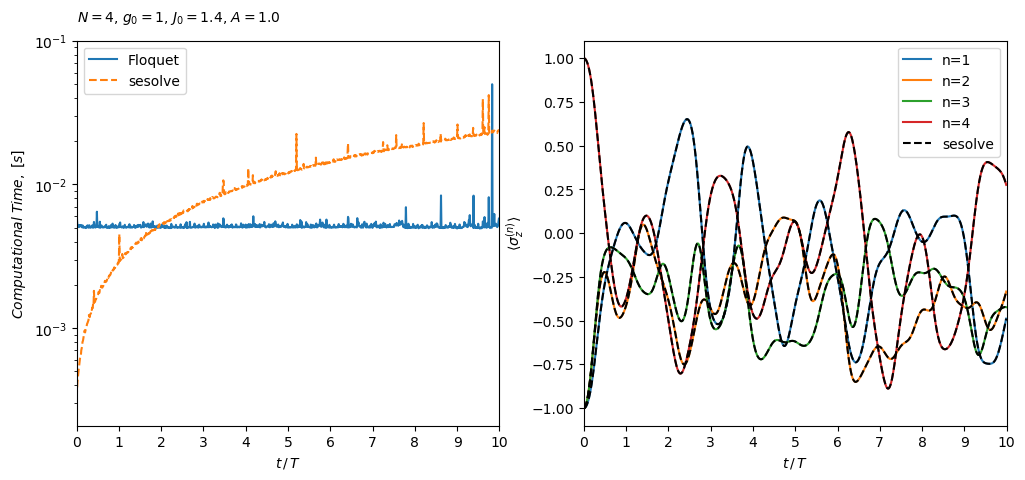

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = axs[0]
axs[0].plot(tlist / T, computational_time_floquet, "-")
axs[0].plot(tlist / T, computational_time_sesolve, "--")

axs[0].set_yscale("log")
axs[0].set_yticks(np.logspace(-3, -1, 3))
lg = []
for i in range(N):
    axs[1].plot(tlist / T, np.real(expect_floquet[i, :]), "-")
    lg.append(f"n={i+1}")
for i in range(N):
    axs[1].plot(tlist / T, np.real(expect_sesolve[i, :]), "--", color="black")
lg.append("sesolve")

axs[0].set_xlabel(r"$t \, / \, T$")
axs[1].set_xlabel(r"$t \, / \, T$")
axs[0].set_ylabel(r"$Computational \; Time,\; [s]$")
axs[1].set_ylabel(r"$\langle \sigma_z^{{(n)}} \rangle$")
axs[0].legend(("Floquet", "sesolve"))
axs[1].legend(lg)
xticks = np.rint(np.linspace(0, N_T, N_T + 1, endpoint=True))
axs[0].set_xticks(xticks)
axs[0].set_xlim([0, N_T])
axs[1].set_xticks(xticks)
axs[1].set_xlim([0, N_T])
txt = f"$N={N}$, $g_0={g0}$, $J_0={J0}$, $A={A}$"
axs[0].text(0.0, 1.05, txt, transform=axs[0].transAxes)

plt.show()

## References

[1] [Floquet, Annales scientifiques de l’École Normale Supérieure (1883)](http://www.numdam.org/articles/10.24033/asens.220/)

[2] [Shirley, Phys.Rev. (1965)](https://link.aps.org/doi/10.1103/PhysRev.138.B979)

[3] [QuTiP 5: The Quantum Toolbox in Python](https://arxiv.org/abs/2412.04705)

## About

In [14]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


## Testing

In [15]:
for i in range(N):
    assert np.allclose(
        np.real(expect_floquet[i, :]), np.real(expect_sesolve[i, :]), atol=1e-5
    ), f"floquet and sesolve solutions for Ising chain element {i} deviate."